# Adversarial Search: Playing "Mean" Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it in any column. All disks above the removed disk will fall down one position. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

__Initial state:__ empty board

__Actions:__ column number to put token(column not full)/ column number to remove opponent's token(the bottom spot of the column is opponent's token) and column number to put opponent's token

__Transition model:__ put the token on the lowest empty spot in the chosen column/ remove the opponent's token away from the chosen column and put it to the lowest empty spot to the chosen column.

__Test for the terminal state:__ if one player have 4 token connected(horizontal, vertical, or diagonal)/ if it is all the spots have been filled in and nobody wins(draw)

__Utility for terminal states:__ -1 for lose, 0 for draw and +1 for win

How big is the state space? Give an estimate and explain it.

__State space__

If the player want to use 'play' part, he have 7 choices. The bottom line can have at most 6 opponent's disc(-1, -1, -1, 1, -1, -1, -1), so the player can have 6 * 7 chocies if use the 'mean' part. So the player can have 6 * 7 + 7 = 49 choices each move at most. If we limit the total number of move to 100, the an upper bound of the state space will be 49^100. 

Since we have 6 * 7 = 42 spots on the board, and the status of each spot can be empty, yellow or red, which make the state space has a tighter upper bound 3^42.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

__Size of game tree__

The game tree can have at most 100 levels since we set the move limit to 100, and each node in the tree can have 49 branches. Therefore, number of total nodes in the game tree can at most be 1 + 49 + 49^2 + ... + 49^99 = 1.02 * 49^99.

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [1]:
import numpy as np

def empty_board(shape=(4, 4)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

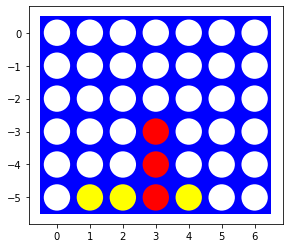

In [2]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $results(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [3]:
# find the lowest empty spot in the chosen column
def lowest_empty_spot(board, column):
    height = len(board)
    for i in range(height):
        if board[height - i - 1][column] == 0:
            empty_spot = height - i - 1
            return empty_spot
        
# find the other player
def other(player): 
    if player == 1: return -1
    else: return 1

# get all possible actions
def actions(board, player):
    actions = list()
    
    # if player want to put his own disc
    for i in np.where(np.array(board[0]) == 0)[0]:
        actions.append(['play', i])
        
    # if player want to remove opponent's disc
    for i in np.where(np.array(board[len(board) - 1]) == other(player))[0]:
        for j in np.where(np.array(board[0]) == 0)[0]:
            actions.append(['mean', i, j])
        if(['mean', i, i] not in actions):
            actions.append(['mean', i, i])
            
    return actions

# the new state after one action
def result(board, action, player):
    board = board.copy()
    
    # player choose to play
    if(action[0] == 'play'):
        pos = lowest_empty_spot(board, action[1])
        board[pos][action[1]] = player
        
    # player choose to mean
    else:
        # each disc in the chosen column fall down one spot
        for i in range(len(board) - 1):
            board[len(board) - i - 1][action[1]] = board[len(board) - i - 2][action[1]]
        board[0][action[1]] = 0
        
        # put opponent's disc to a new column
        pos = lowest_empty_spot(board, action[2])
        board[pos][action[2]] = other(player)
    
    return board

# the transition model
def results(board, action, player):
    if player == -1: opponent = 1
    else: opponent = -1
    
    board = board.copy()
    
    # player's move
    board = result(board, action, player)
    
    # opponent's possible moves
    results = list()
    opponent_actions = actions(board, other(player))
    
    # board is full
    if len(opponent_actions) < 1 : return [board]
    
    # the new states after all opponent's possible moves
    for opponent_action in opponent_actions:
        possible_board = result(board, opponent_action, other(player))
        results.append(possible_board) 
    
    return results

# the utility function
def utility(board):
    height = len(board)
    width = len(board[0])
    
    # check if there are 4 discs connected horizontally
    for i in range(height):
        for j in range(width - 3):
            if(board[i][j] + board[i][j + 1] + board[i][j + 2] + board[i][j + 3] == 4):
                return 1
            if(board[i][j] + board[i][j + 1] + board[i][j + 2] + board[i][j + 3] == -4):
                return -1
    
    # check if there are 4 discs connected vertically
    for j in range(width):
        for i in range(height - 3):
            if(board[i][j] + board[i + 1][j] + board[i + 2][j] + board[i + 3][j] == 4):
                return 1
            if(board[i][j] + board[i + 1][j] + board[i + 2][j] + board[i + 3][j] == -4):
                return -1
            
    # check if there are 4 discs connected diagnoally
    for i in range(height - 3):
        for j in range(width - 3):
            if(board[i][j] + board[i + 1][j + 1] + board[i + 2][j + 2] + board[i + 3][j + 3] == 4):
                return 1
            if(board[i][j] + board[i + 1][j + 1] + board[i + 2][j + 2] + board[i + 3][j + 3] == -4):
                return -1
            if(board[i + 3][j] + board[i + 2][j + 1] + board[i + 1][j + 2] + board[i][j + 3] == 4):
                return 1
            if(board[i + 3][j] + board[i + 2][j + 1] + board[i + 1][j + 2] + board[i][j + 3] == -4):
                return -1
    
    # check for draw
    if 0 not in board:
        return 0
    
    return None

# check for terminal states
def terminal(board): 
    return utility(board) != None

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action.

In [4]:
def random_player(board, player):
    action = actions(board, player)
    choice = np.random.randint(0, len(action))
    return action[choice]

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how ranom agents can play against each other.

How often does each player win? Is the result expected?

In [6]:
def switch_player(player, player1_algorithm, player2_algorithm):
    if player == 1:
        return -1, player2_algorithm
    else:
        return 1, player1_algorithm
    
def environment(player1, player2, n = 1000):
    results = {1: 0, -1: 0, 0: 0}
    
    for i in range(n):
        move = 0
        board = empty_board()
        player, player_algorithm = 1, player1
        
        while move < 100:
            move += 1
            
            # if the agent use alpha_beta_search, set the move limit to be 20
            if(player_algorithm == alpha_beta_search):
                action = player_algorithm(board, 10, player)
            else:
                action = player_algorithm(board, player)
            
            board = result(board, action, player)
            
            winner = utility(board)   
            if winner != None:
                results[winner] += 1
                break
                
            if move == 100:
                results[0] += 1
            
            player, player_algorithm = switch_player(player, player1, player2)
    
    return results

environment(random_player, random_player)

{1: 799, -1: 194, 0: 7}

The proportion of the player who go first winning is around 80% and of the player who go second winning is around 20%. This is a expected result since the player who go first have a larger possibility to win. 

## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting from a given board and specifying the player.

You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).


__Note:__ The game tree for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$).

In [21]:
import math

def alpha_beta_search(board, move_limit = +math.inf, player = 1):
    depth = 0
    value, move = max_value_ab(move_limit, depth, board, player, -math.inf, +math.inf)
    return move

def max_value_ab(move_limit, depth, state, player, alpha, beta):
    depth += 1
       
    # return utility of state is a terminal state
    value = utility(state)
    if value is not None: return value, None
    if depth > move_limit: return 0, None
        
    value, move = -math.inf, None
    # check all possible actions in the state, update alpha and return move with the largest value
    for action in actions(state, player):
        value2, action2 = min_value_ab(move_limit, depth, result(state, action, player), player, alpha, beta)
        if value2 > value:
            value, move = value2, action
            alpha = max(alpha, value)
        if value >= beta: return value, move
    
    return value, move

def min_value_ab(move_limit, depth, state, player, alpha, beta):
    depth += 1
    
    # return utility of state is a terminal state
    value = utility(state)
    if value is not None: return value, None
    if depth > move_limit: return 0, None
    
    value, move = +math.inf, None
    # check all possible actions in the state, update beta and return move with the smallest value
    for action in actions(state, other(player)):
        value2, action2 = max_value_ab(move_limit, depth, result(state, action, other(player)), player, alpha, beta)
        if value2 < value:
            value, move = value2, action
            beta = min(beta, value)
        if value <= alpha: return value, move
    
    return value, move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [7]:
board = np.array([[0, 0, 0, 0],
                  [-1, 1, -1, 1],
                  [1, -1, -1, 1],
                  [1, -1, 1, 1]])
print(alpha_beta_search(board))

board = np.array([[0, 0, 0, 0],
                  [0, 0, 0, -1],
                  [0, 0, -1, -1],
                  [0, 1, 1, 1]])
print(alpha_beta_search(board))

board = np.array([[0, 0, 0, 0],
                  [1, 1, 0, 1],
                  [-1, 1, -1, -1],
                  [1, -1, -1, -1]])
print(alpha_beta_search(board))

board = np.array([[0, 0, 0, 0],
                  [-1, 1, 0, 0],
                  [1, -1, 1, -1],
                  [-1, -1, -1, 1]])
print(alpha_beta_search(board))

board = np.array([[0, 0, 0, 0],
                  [-1, 1, 1, -1],
                  [-1, 1,-1, 1],
                  [-1, 1, -1, 1]])
print(alpha_beta_search(board))

['play', 3]
['play', 0]
['play', 2]
['play', 0]
['play', 1]


This Minimax Search with Alpha-Beta Pruning can spot winning opportunities.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

Since the game is so large, if we use an empty board to run the agent, it will take too much time. So we add some discs on the board ahead and find out how long does it take to make a move on different sizes of board.

In [8]:
board = np.array([[0, 0, 0, 0],
                  [1, -1, 1, -1],
                  [-1, 1, -1, -1],
                  [1, 1, -1, 1]])
%time display(alpha_beta_search(board, 10))

board = np.array([[0, 0, 0, 0, 0],
                  [-1, 1, -1, 1, -1],
                  [-1, -1, -1, 1, -1],
                  [1, 1, -1, 1, 1]])
%time display(alpha_beta_search(board, 12))

board = np.array([[0, 0, 0, 0, 0, 0],
                  [-1, 1, -1, 1, -1, 1],
                  [-1, -1, -1, 1, -1, -1],
                  [1, 1, -1, 1, 1, 1]])
%time display(alpha_beta_search(board, 14))

board = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [-1, 1, -1, 1, -1, 1, -1],
                  [1, -1, -1, -1, 1, -1, -1],
                  [1, 1, 1, -1, 1, 1, 1]])
%time display(alpha_beta_search(board, 14))

['play', 3]

CPU times: user 59.6 ms, sys: 5 ms, total: 64.6 ms
Wall time: 67.5 ms


['play', 2]

CPU times: user 920 ms, sys: 11.8 ms, total: 932 ms
Wall time: 928 ms


['play', 2]

CPU times: user 39 s, sys: 193 ms, total: 39.2 s
Wall time: 39 s


['play', 2]

CPU times: user 7min 9s, sys: 2.38 s, total: 7min 11s
Wall time: 7min 9s


### Move ordering

Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

__Definition of the move ordering:__

1. Always use 'play' prior to 'mean'
2. When use 'play', put the disc on the center prior to sides.
3. When use 'mean', put opponent's disc on the sides prior to center

In [22]:
def actions(board, current_player):
    actions = list()
    actions_priority = list()
    count_play = 0
    count_mean = 0
    
    # if player want to put his own disc
    for i in np.where(np.array(board[0]) == 0)[0]:
        actions.append(['play', i])
        count_play += 1
        
    # if player want to remove opponent's disc
    for i in np.where(np.array(board[len(board) - 1]) == other(current_player))[0]:
        for j in np.where(np.array(board[0]) == 0)[0]:
            actions.append(['mean', i, j])
            count_mean += 1
        if(['mean', i, i] not in actions):
            actions.append(['mean', i, i])
            count_mean += 1
        
    # order the action list
    board_size = len(board[0])
    if board_size % 2 == 0:
        play1 = list()
        for i in range(int(board_size / 2)):
            play1.append(i)
        play2 = play1[::-1]
        priority_play = play1 + play2
        priority_mean = play2 + play1
        
    if board_size % 2 == 1:
        play1 = list()
        for i in range(int(board_size / 2)):
            play1.append(i)
        play2 = play1[::-1]
        play1.append(int(board_size / 2))
        priority_play = play1 + play2
        priority_mean = play1[::-1] + play1
        del priority_mean[int(board_size / 2)]
                          
    for i in range(count_play + count_mean):
        if actions[i][0] == 'play':
            actions_priority.append([priority_play[actions[i][1]] + 10, actions[i]])
        else:
            actions_priority.append([priority_mean[actions[i][2]], actions[i]])

    actions =[a for _,a in sorted(actions_priority, reverse=True)]
    return actions

In [25]:
board = np.array([[0, 0, 0, 0],
                  [1, -1, 1, -1],
                  [-1, 1, -1, -1],
                  [1, 1, -1, 1]])
%time display(alpha_beta_search(board, 10))

board = np.array([[0, 0, 0, 0, 0],
                  [-1, 1, -1, 1, -1],
                  [-1, -1, -1, 1, -1],
                  [1, 1, -1, 1, 1]])
%time display(alpha_beta_search(board, 12))

board = np.array([[0, 0, 0, 0, 0, 0],
                  [-1, 1, -1, 1, -1, 1],
                  [-1, -1, -1, 1, -1, -1],
                  [1, 1, -1, 1, 1, 1]])
%time display(alpha_beta_search(board, 14))

board = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [-1, 1, -1, 1, 1, -1, -1],
                  [1, -1, -1, -1, 1, -1, -1],
                  [1, 1, 1, -1, 1, 1, 1]])
%time display(alpha_beta_search(board, 14))

['play', 3]

CPU times: user 55.1 ms, sys: 3.01 ms, total: 58.1 ms
Wall time: 58.4 ms


['play', 2]

CPU times: user 472 ms, sys: 13.1 ms, total: 485 ms
Wall time: 481 ms


['play', 3]

CPU times: user 367 ms, sys: 7.05 ms, total: 374 ms
Wall time: 336 ms


['play', 4]

CPU times: user 292 ms, sys: 5.02 ms, total: 297 ms
Wall time: 298 ms


This table shows how the move ordering influence the time it taks to make a move.

| Size     | Without a move ordering | With a move ordering |
|----------|------------------|---------------------|
| 4x4     | 67.5ms | 58.4ms | 
| 4x5   | 928ms | 481ms | 
| 4x6 | 39s | 336ms | 
| 4x7 | 7min 9s | 298ms | 

As we can see from the table, a move ordering can reduce the time it takes to make a move.

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

__Answer__
1. Always put the first disc on the center row without searching the game tree.
2. Set a limit for the number of total move. For example, if the board is 4* 4, set the move limit to be 20.
3. If there is a immediate win oppotunity or opponent has a immediate oppotunity, put the disc on that to win or block opponent.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

The Minimax Search agent always win since it always finds a optimal move while random agent not.

In [10]:
environment(alpha_beta_search, random_player, 10)

{1: 10, -1: 0, 0: 0}

## Task 4: Heuristic Alpha-Beta Tree Search [3 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [11]:
'''
Heuristic for utility of state. Returns score for a node:
1. For terminal states it returns the utility. 
2. For non-terminal states:
The value of a possible 3 is set to be 0.1. For example, if one player have [0,1,1,1] or [1,1,1,0] or [1,0,1,1] on the board,
the score will plus 0.1. On the contrary, if the opponent have a possible 3, socre minus 0.1
The value of a possible 2 is set to be 0.02. For example, if one player have [0,1,1,0] or [0,0,1,1] or [1,1,0,0] on the board,
the score will plus 0.02. On the contrary, if the opponent have a possible 2, socre minus 0.02
3. Different evaluation:
Value of a possible 3 for the second evaluation is 0.05
Value of a possible 2 for the second evaluation is 0.03
    
Function Returns: heuistic value, terminal?
'''
def evaluation(board, mode):
    # return utility if it is terminal state
    value = utility(board)
    if value is not None: return value, True

    if mode == 1:
        addition3 = 0.1
        addition2 = 0.02
    else:
        addition3 = 0.05
        addition2 = 0.03
    
    # if it isn't terminal state
    score = 0.0
    height = len(board)
    width = len(board[0])
    
    # check if there is a 3 that is possible to win horizontally
    for i in range(height):
        for j in range(width - 3):
            if(board[i][j] + board[i][j + 1] + board[i][j + 2] + board[i][j + 3] == 3):
                score += addition3
            if(board[i][j] + board[i][j + 1] + board[i][j + 2] + board[i][j + 3] == -3):
                score -= addition3
    
    # check if there is a 3 that is possible to win vertically
    for j in range(width):
        for i in range(height - 3):
            if(board[i][j] + board[i + 1][j] + board[i + 2][j] + board[i + 3][j] == 3):
                score += addition3
            if(board[i][j] + board[i + 1][j] + board[i + 2][j] + board[i + 3][j] == -3):
                score -= addition3
            
    # check if there is a 3 that is possible to win diagonally
    for i in range(height - 3):
        for j in range(width - 3):
            if(board[i][j] + board[i + 1][j + 1] + board[i + 2][j + 2] + board[i + 3][j + 3] == 3):
                score += addition3
            if(board[i][j] + board[i + 1][j + 1] + board[i + 2][j + 2] + board[i + 3][j + 3] == -3):
                score -= addition3
            if(board[i + 3][j] + board[i + 2][j + 1] + board[i + 1][j + 2] + board[i][j + 3] == 3):
                score += addition3
            if(board[i + 3][j] + board[i + 2][j + 1] + board[i + 1][j + 2] + board[i][j + 3] == -3):
                score -= addition3
            
    # check if there are 2 discs connected horizontally
    for i in range(height):
        for j in range(width - 3):
            horizontal = [board[i][j], board[i][j + 1], board[i][j + 2], board[i][j + 3]]
            sum1 = board[i][j] + board[i][j + 1] + board[i][j + 2] + board[i][j + 3]
            
            if(sum1 == 2 and -1 not in horizontal):
                score += addition2
            if(sum1 == -2 and 1 not in horizontal):
                score -= addition2
    
    # check if there are 2 discs connected vertically
    for j in range(width):
        for i in range(height - 3):
            if(board[i + 2][j] + board[i + 3][j] == 2 and board[i + 1][j] == 0):
                score += addition2
            if(board[i + 2][j] + board[i + 3][j] == -2 and board[i + 1][j] == 0):
                score -= addition2
            
    # check if there are 2 discs connected diagonally
    for i in range(height - 3):
        for j in range(width - 3):
            diagonal1 = [board[i][j], board[i + 1][j + 1], board[i + 2][j + 2], board[i + 3][j + 3]]
            diagonal2 = [board[i + 3][j], board[i + 2][j + 1], board[i + 1][j + 2], board[i][j + 3]]
            
            sum1 = board[i][j] + board[i + 1][j + 1] + board[i + 2][j + 2] + board[i + 3][j + 3]
            sum2 = board[i + 3][j] + board[i + 2][j + 1] + board[i + 1][j + 2] + board[i][j + 3]
            
            if(sum1 == 2 and -1 not in diagonal1):
                score += addition2
            if(sum1 == -2 and 1 not in diagonal1):
                score -= addition2
            if(sum2 == 2 and -1 not in diagonal2):
                score += addition2
            if(sum2 == -2 and 1 not in diagonal2):
                score -= addition2
    
    return score, False

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [12]:
def heuristic_alpha_beta_search(board, cutoff, player = 1, mode = 1):
    value, move = max_value_ab(board, player, -math.inf, +math.inf, 0, cutoff, mode)
    return move

def max_value_ab(state, player, alpha, beta, depth, cutoff, mode):
    # check if it reaches cut off or terminal
    value, terminal = evaluation(state, mode)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = value, value
        return value, None
    
    value, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for action in actions(state, player):
        value2, action2 = min_value_ab(result(state, action, player), player, alpha, beta, depth + 1, cutoff, mode)
        if value2 > value:
            value, move = value2, action
            alpha = max(alpha, value)
        if value >= beta: return value, move
    
    return value, move

def min_value_ab(state, player, alpha, beta, depth, cutoff, mode):
    # check if it reaches cut off or terminal
    value, terminal = evaluation(state, mode)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = value, value 
        return value, None
    
    value, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for action in actions(state, other(player)):
        value2, action2 = max_value_ab(result(state, action, other(player)), player, alpha, beta, depth + 1, cutoff, mode)
        if value2 < value:
            value, move = value2, action
            beta = min(beta, value)
        if value <= alpha: return value, move
    
    return value, move

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

The Heuristic can spot the winning opportunities.

In [13]:
board = np.array([[0, 0, 0, 0],
                  [-1, 1, -1, 1],
                  [1, -1, -1, 1],
                  [1, -1, 1, 1]])
print(heuristic_alpha_beta_search(board, 10, 1))

board = np.array([[0, 0, 0, 0],
                  [0, 0, 0, -1],
                  [0, 0, -1, -1],
                  [0, 1, 1, 1]])
print(heuristic_alpha_beta_search(board, 10, 1))

board = np.array([[0, 0, 0, 0],
                  [1, 1, 0, 1],
                  [-1, 1, -1, -1],
                  [1, -1, -1, -1]])
print(heuristic_alpha_beta_search(board, 10, 1))

board = np.array([[0, 0, 0, 0],
                  [-1, 1, 0, 0],
                  [1, -1, 1, -1],
                  [-1, -1, -1, 1]])
print(heuristic_alpha_beta_search(board, 10, 1))

board = np.array([[0, 0, 0, 0],
                  [-1, 1, 1, -1],
                  [-1, 1,-1, 1],
                  [-1, 1, -1, 1]])
print(heuristic_alpha_beta_search(board, 10, 1))

['play', 3]
['play', 0]
['play', 2]
['play', 0]
['play', 1]


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [15]:
board = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])
%time display(heuristic_alpha_beta_search(board, 5))

board = np.array([[0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0]])
%time display(heuristic_alpha_beta_search(board, 5))

board = np.array([[0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0]])
%time display(heuristic_alpha_beta_search(board, 5))

board = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0]])
%time display(heuristic_alpha_beta_search(board, 5))

['play', 2]

CPU times: user 87.6 ms, sys: 3.04 ms, total: 90.6 ms
Wall time: 86.6 ms


['play', 2]

CPU times: user 168 ms, sys: 6.03 ms, total: 174 ms
Wall time: 168 ms


['play', 3]

CPU times: user 395 ms, sys: 28.2 ms, total: 423 ms
Wall time: 388 ms


['play', 3]

CPU times: user 764 ms, sys: 87.7 ms, total: 852 ms
Wall time: 733 ms


### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [16]:
def switch(player):
    # player 1 algorithm sets cutoff to be 10 and uses the first way of evaluation
    # player 2 algorithm sets cutoff to be 5 and uses the second way of evaluation
    if player == 1:
        return -1, 5, 2
    else:
        return 1, 10, 1
    
def battle():    
    move = 0
    board = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])
    player, cutoff, mode = 1, 10, 1

    while move < 100:
        move += 1
        action = heuristic_alpha_beta_search(board, cutoff, player, mode)
        board = result(board, action, player)

        winner = utility(board)     
        if winner != None:
            if winner == 1:
                return "Player 1 wins"
            elif winner == -1:
                return "Player 2 wins"
            else:
                return "Draw"

        if move == 100:
            return "Draw"

        player, cutoff, evaluation = switch(player)
        
battle()

'Player 1 wins'

The Player 1 wins beacause it uses a larger cutoff value which mean that it will search deeper into the game tree. And its evaluation function is better since score of a possible 3 will be much larger than a possible 2, while Player 2 uses a evaluation function whose a possible 2 score is close to a possible 3

## Tournament task [+ 1 to 5 bonus point will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [17]:
def playout(board, action, player):
    board = result(board, action, player)
    player = other(player)
    
    while(True):
        # check if it has reached the terminal state
        winner = utility(board)
        if winner is not None: return(winner)
        
        # generate random playout
        choice = np.random.randint(0, len(actions(board, player)))
        action = actions(board, player)[choice]
        board = result(board, action, player)
        
        # change player
        player = other(player)
        
def playouts(board, action, player, n):
    return [playout(board, action, player) for i in range(n)]

def pmcs(board, n, player):
    action = actions(board, player)
    n = math.floor(n/len(action))
    
    max = np.mean(playouts(board, action[0], player, n))
    best_move = action[0]
    for i in action:
        current = np.mean(playouts(board, i, player, n))
        if current > max:
            max = current
            best_move = i
    return best_move

In [18]:
board = np.array([[0, 0, 0, 0],
                  [-1, 1, -1, 1],
                  [1, -1, -1, 1],
                  [1, -1, 1, 1]])
print(pmcs(board, 10000, 1))

board = np.array([[0, 0, 0, 0],
                  [0, 0, 0, -1],
                  [0, 0, -1, -1],
                  [0, 1, 1, 1]])
print(pmcs(board, 10000, 1))

board = np.array([[0, 0, 0, 0],
                  [1, 1, 0, 1],
                  [-1, 1, -1, -1],
                  [1, -1, -1, -1]])
print(pmcs(board, 10000, 1))

board = np.array([[0, 0, 0, 0],
                  [-1, 1, 0, 0],
                  [1, -1, 1, -1],
                  [-1, -1, -1, 1]])
print(pmcs(board, 10000, 1))

board = np.array([[0, 0, 0, 0],
                  [-1, 1, 1, -1],
                  [-1, 1,-1, 1],
                  [-1, 1, -1, 1]])
print(pmcs(board, 10000, 1))

['play', 3]
['play', 0]
['play', 2]
['play', 0]
['play', 1]


The search can spot the winning oppotunities like Minimax Search with Alpha-Beta Pruning Algorithm and Heruristic Alpha-Beta Tree Search.

In [19]:
board = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])
%time display(pmcs(board, 10000, 1))

board = np.array([[0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0]])
%time display(pmcs(board, 10000, 1))

board = np.array([[0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0]])
%time display(pmcs(board, 10000, 1))

board = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0]])
%time display(pmcs(board, 10000, 1))

['play', 2]

CPU times: user 16.3 s, sys: 32.9 ms, total: 16.4 s
Wall time: 16.3 s


['play', 1]

CPU times: user 22.7 s, sys: 40.9 ms, total: 22.7 s
Wall time: 22.7 s


['play', 5]

CPU times: user 29.2 s, sys: 63.1 ms, total: 29.2 s
Wall time: 29.2 s


['play', 4]

CPU times: user 36.2 s, sys: 74.9 ms, total: 36.3 s
Wall time: 36.2 s


### Best First Move

How would you determine what the best first move for a standard board ($6 \times 7$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [29]:
board = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0]])
pmcs(board, 5000, 1)

['play', 3]

From the output of Pure Monte Carlo Search Algorithm, the best move for an empty 6 * 7 board is putting the disc to the center column.